## Import & Process Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Pipeline with Sampleset

In [2]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [4]:
def import_dataset(img_path, data_path):
    img_url = sorted(glob.glob(img_path+"/*.jpg"))
    csv_names = [i for i in glob.glob(data_path+'/*.csv')]
    df = pd.concat([pd.read_csv(f) for f in csv_names]).sort_values('name').reset_index(drop=True)
    df['image'] = img_url
    return df

def clean_dataset(df):
    dataset = df.copy()
    dataset = dataset[['meta.clinical.diagnosis', 'image']]
    dataset = dataset[dataset['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
    dataset.columns = ['diagnosis', 'image']
    dataset['diagnosis'] = (dataset['diagnosis'] == 'melanoma').astype(int)
    return dataset

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set

In [5]:
# Importing and creating test set. Returns X & y.
test_df = import_dataset('img_sample/img_test','data_sample/data_test')
test_df_cleaned = clean_dataset(test_df)
X_test, y_test = create_X_y(test_df_cleaned)

#### Creating Train Set

In [6]:
# Train Set
path = "img_sample/img_train"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

negative_csv =[i for i in glob.glob('data_sample/data_train/0/*.csv')]
positive_csv =[i for i in glob.glob('data_sample/data_train/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [7]:
# Train Set
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [8]:
# Create X and y for Train set
y = lbl_img_cl['diagnosis']
X = []
for i in fileimages:
    image = load_and_preprocess_image(i)
    X.append(np.asarray(image))

In [9]:
# Train/test split for Train Set
X_train, X_val, y_train, y_val = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)

#### Train Model

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 3s 130ms/step - loss: 0.6980 - accuracy: 0.5201 - val_loss: 0.7194 - val_accuracy: 0.2767
Epoch 2/100
25/25 [==============================] - 3s 116ms/step - loss: 0.6724 - accuracy: 0.5702 - val_loss: 0.7139 - val_accuracy: 0.3433
Epoch 3/100
25/25 [==============================] - 3s 116ms/step - loss: 0.6531 - accuracy: 0.6316 - val_loss: 0.8196 - val_accuracy: 0.3467
Epoch 4/100
25/25 [==============================] - 3s 117ms/step - loss: 0.6106 - accuracy: 0.6830 - val_loss: 0.7084 - val_accuracy: 0.4867
Epoch 5/100
25/25 [==============================] - 3s 117ms/step - loss: 0.5750 - accuracy: 0.7155 - val_loss: 1.1023 - val_accuracy: 0.4100
Epoch 6/100
25/25 [==============================] - 3s 115ms/step - loss: 0.5737 - accuracy: 0.7306 - val_loss: 0.8687 - val_accuracy: 0.4167
Epoch 7/100
25/25 [==============================] - 3s 116ms/step - loss: 0.5784 - accuracy: 0.7018 - val_loss: 0.8936 - val_accuracy: 0.3933

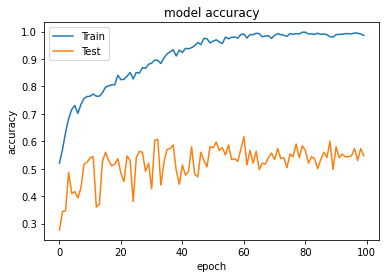

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

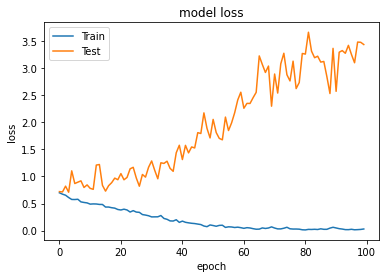

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        1

## Evalaution

In [16]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.3f}'.format(tp/(tp+fn)))
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.3f}'.format(roc_auc_score(y_test, y_pred)))

In [17]:
# Validation Set
val_loss1, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Val  set accuracy {:5.2f}%'.format(100*val_acc))
# Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))

Val  set accuracy 74.50%
Test set accuracy 54.67%


In [25]:
threshold = 0.4

In [26]:
# Validation Set
result = (model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[78 22]
 [26 74]]
Recall:    0.780
Precision: 0.750
Accuracy:  0.760
ROC AUC:   0.760


In [27]:
# Test Set
result = (model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 41  36]
 [100 123]]
Recall:    0.532
Precision: 0.291
Accuracy:  0.547
ROC AUC:   0.542


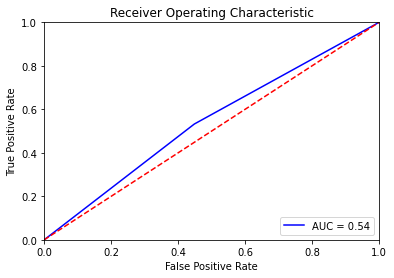

In [21]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [258]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: too many indices for array

In [248]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 432x288 with 0 Axes>

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [266]:
len(roc_curve(y_test[:, 0], y_score[:, 0]))

3

In [267]:
y.shape

(150, 3)

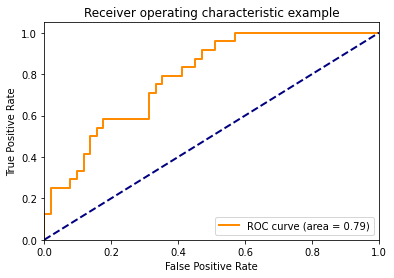

In [264]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [245]:
## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(fileimages)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

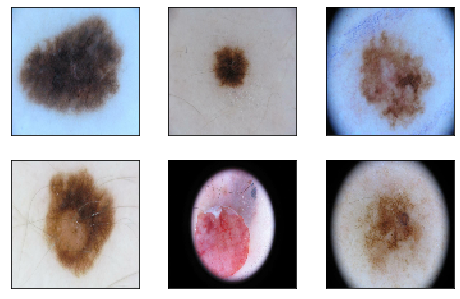

In [234]:
plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(6)):
    plt.subplot(3,3,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])